# 6.1 - Introduction to Stochastic Programming - Newsvendor Problem
Prepared by: Nickolas Freeman, PhD

This notebook demonstrates the use of kernel density estimataton and stochastic programming in the context of sourcing decisions. Specifically, it shows how the two tools may be combined to solve a *newsvendor problem* when demand follows a bimodal distribution. A description of the newsvendor problem, copied from Wikipedia on 1/3/2018, follows:

>The newsvendor (or newsboy or single-periodor perishable) model is a mathematical model in operations management and applied economics used to determine optimal inventory levels. It is (typically) characterized by fixed prices and uncertain demand for a perishable product. If the inventory level is $q$, each unit of demand above $q$ is lost in potential sales. This model is also known as the Newsvendor Problem or Newsboy Problem by analogy with the situation faced by a newspaper vendor who must decide how many copies of the day's paper to stock in the face of uncertain demand and knowing that unsold copies will be worthless at the end of the day.
>
>The standard newsvendor profit function is $\mathbb{E}[Profit] =\mathbb{E}\left[p\min(q,D)\right]-cq$, where $D$ is a random variable with probability distribution $F$ representing demand, each unit is sold for price $p$ and purchased for price $c$, $q$ is the number of units stocked, and $\mathbb{E}$ is the expectation operator. The solution to the optimal stocking quantity of the newsvendor which maximizes expected profit is:
>
> $$q=F^{-1}\left(\frac{p-c}{p}\right),$$ 
> where $F^{-1}$ denotes the inverse cumulative distribution function of $D$.
>
>Intuitively, this ratio, referred to as the critical fractile, balances the cost of being understocked (a lost sale worth $(p-c)$) and the total costs of being either overstocked or understocked (where the cost of being overstocked is the inventory cost, or $c$ so total cost is simply $p$).
>
>The critical fractile formula is known as Littlewood's rule in the yield management literature.

For the purpose of demonstration, we will begin by randomly generating some demand data for a single product. The following code block imports the several libraries we will be using and sets some defaults.

In [1]:
import pathlib

from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Set pandas default display format for floating-point numbers
pd.set_option('display.float_format','{:20,.2f}'.format)
# Set the default columns to display for pandas
pd.set_option('display.max_columns', 50)
import pulp

import OM527_functions as omf

The following code block generates the demand data and plots it using a histogram.

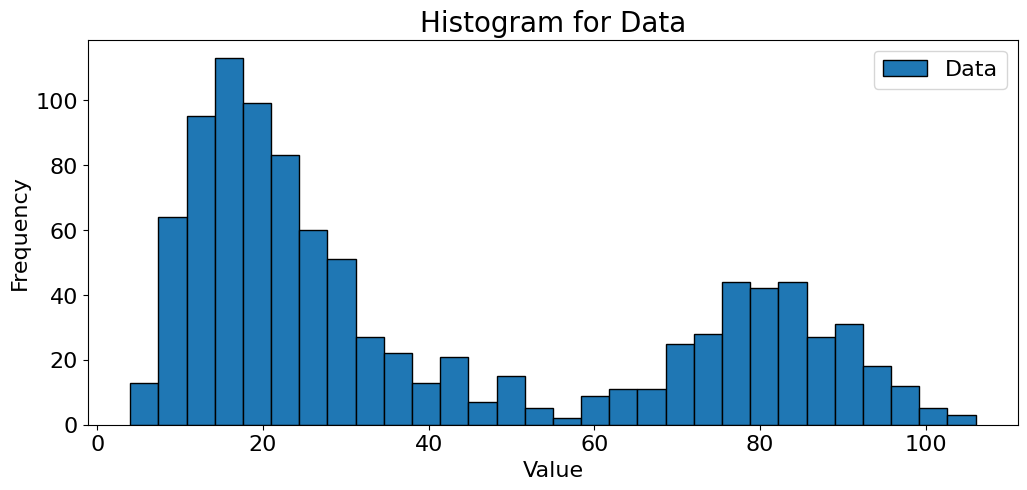

In [2]:
num_bins = 30
np.random.seed(42)
sample_size = 1000

dist_A = np.random.lognormal(3, 0.50, sample_size)
dist_B = np.random.normal(80, 10, sample_size)

random_numbers = np.random.rand(sample_size)
random_numbers > 0.7

data = dist_A[random_numbers <= 0.7]
data = np.append(data, dist_B[random_numbers > 0.7])
np.random.shuffle(data)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.hist(data, bins = num_bins, label = 'Data', edgecolor = 'k', density = False)
ax.set_xlabel("Value", fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)
ax.set_title('Histogram for Data', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 16,loc=1)
plt.show()

The following code block uses the functions available in the `pyopsmgmt` package to fit a kernel density estimat for the data and randomly generates a sample comprised of 10,000 points. This sample is stored in an object named `benchmark` because we will use this sample as a point of comparison during our discussion of stochastic programming. 

In [3]:
best_params = omf.distfit.fit_best_kde(data)
pdf = omf.distfit.pdf_from_kde(data, 
                            bandwidth = best_params['bandwidth'],
                            kernel= best_params['kernel'])
benchmark = omf.distfit.trunc_kde_sample(pdf['x'], 
                                      pdf['y'], 
                                      sample_size = 10000)

The following code block plots the original data sample and our benchmark sample just to demonstrate the fit.

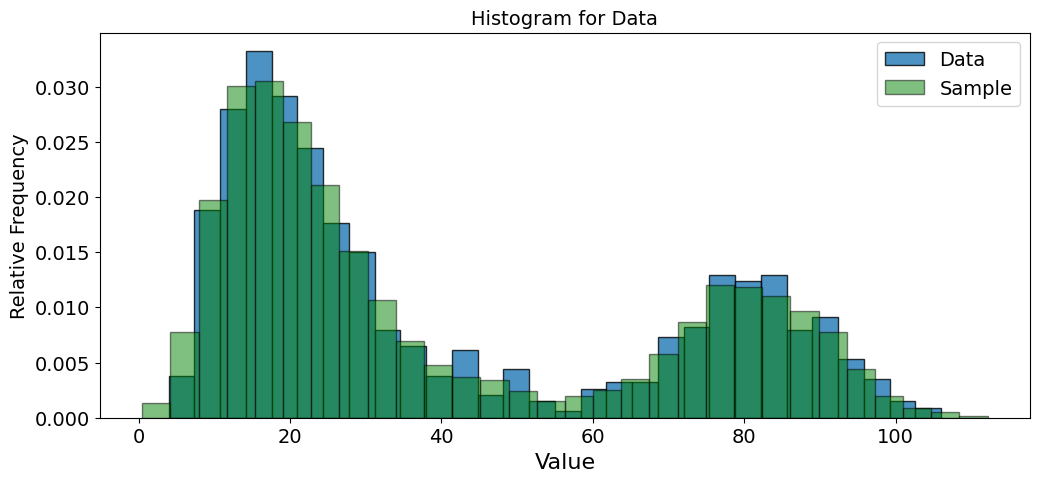

In [4]:
num_bins = 30

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.hist(data, 
        bins = num_bins, 
        label = 'Data', 
        alpha = 0.8, 
        edgecolor = 'k', 
        density = True)

ax.hist(benchmark, 
        bins = num_bins, 
        label='Sample', 
        alpha = 0.5, 
        color = 'g', 
        edgecolor = 'k', 
        density = True)

ax.set_xlabel("Value", fontsize = 16)
ax.set_ylabel('Relative Frequency', fontsize = 14)
ax.set_title('Histogram for Data', fontsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.legend(fontsize = 14)
plt.show()

We will turn our attention to solving a newsvendor problem using the demand data. The following code block computes the critical fractile for our example case, where we assume the unit cost equals $\$15$ and the selling price is $\$20$.

In [5]:
unit_cost = 15             # The unit cost the newsvendor pays for each unit of product
sale_price = 20            # The price that the newsvendor sells each unit of product at

Critical_Fractile = (sale_price-unit_cost) / sale_price
print(f'The critical fractile is {Critical_Fractile}')

The critical fractile is 0.25


The critical fractile corresponds to a percentile of the demand distribution. Thus, we need to determine the cumulative distribution function (CDF) for the demand data in order to translate the value to a specific order quantity. The next code block creates two objects that capture the CDF for the data.

In [6]:
cdfx = pdf['x'].copy()
cdfy = pdf['y'].cumsum()

To solve the newsvendor problem using the critical fractile, we need to be able to identify the smallest demand value where the associated value of the CDF is greater than or equal to the critical fractile. The following code block shows how we can use `Numpy`'s `argmax` function to identify such a value in the previously generated CDF. 

In [7]:
CF_index = np.argmax(cdfy > Critical_Fractile)
for i in range(CF_index -2, CF_index +3, 1):
    if (i == CF_index):
        print('----------------------------------------------------------------------------')
        print(f'The value in position {i}, which is {np.round(cdfx[i], 2)}, has a CDF of {np.round(cdfy[i], 3)}.')
        print('    This is the optimal value!!!')
        print('----------------------------------------------------------------------------')
    else:
        print(f'The value in position {i}, which is {np.round(cdfx[i], 2)}, has a CDF of {np.round(cdfy[i], 3)}.')

The value in position 140, which is 16.29, has a CDF of 0.244.
The value in position 141, which is 16.4, has a CDF of 0.247.
----------------------------------------------------------------------------
The value in position 142, which is 16.52, has a CDF of 0.251.
    This is the optimal value!!!
----------------------------------------------------------------------------
The value in position 143, which is 16.64, has a CDF of 0.254.
The value in position 144, which is 16.75, has a CDF of 0.258.


The following code block plots the location of the optimal value along with the histogram for the benchmark sample. 

In [ ]:
num_bins = 30

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.hist(benchmark, bins=num_bins, edgecolor = 'k', density=True, label= 'Benchmark')
ax.axvline(cdfx[CF_index], label='Critical Fractile', color = 'k', linewidth=3)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 16)
ax.set_xlabel("Value",fontsize = 16)
ax.set_ylabel("Relative Frequency",fontsize = 16)
ax.set_title("CDF for Sample",fontsize=25,y=1.05)
plt.show()

We will now build a stochastic programming (SP) model for solving the newsvendor problem. From https://en.wikipedia.org/wiki/Stochastic_programming (accessed 3/28/2018):

> In the field of mathematical optimization, stochastic programming is a framework for modeling optimization problems that involve uncertainty. Whereas deterministic optimization problems are formulated with known parameters, real world problems almost invariably include some unknown parameters. When the parameters are known only within certain bounds, one approach to tackling such problems is called robust optimization. Here the goal is to find a solution which is feasible for all such data and optimal in some sense. **Stochastic programming models** are similar in style but **take advantage of the fact that probability distributions governing the data are known or can be estimated. The goal here is to find some policy that is feasible for all (or almost all) the possible data instances and maximizes the expectation of some function of the decisions and the random variables.** More generally, such models are formulated, solved analytically or numerically, and analyzed in order to provide useful information to a decision-maker.

Specifically, we will use the following mathematical model.

<u>Sets</u><br>
$\Omega$ - set of scenarios<br>

<u>Indices</u><br>
$\omega$ - scenario index, $\omega \in \Omega$,<br>

<u>Parameters</u><br>
$p$  - unit sales price,<br>
$c$ - unit cost,<br>
$d_{\omega}$ - demand in scenario $\omega$,<br>

<u>Decision Variables</u><br>
$Q$ - order quantity,<br>
$S_{\omega}$ - amount sold in scenario $\omega$,<br>


$$\displaystyle Maximize \left(\sum_{\omega \in \Omega}pS_{\omega}\bigg/|\Omega|\right) - cQ$$
$$\displaystyle Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq Q, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q \geq 0.\hspace{1.8cm}~$$


We will use the `pulp` python package to solve the stochastic newsvendor formulation. The `pulp` package is maintained by COIN-OR Foundation, Inc. From https://www.coin-or.org/about-the-foundation/:

>The COIN-OR Foundation, Inc., is a non-profit educational and scientific foundation that was formed in March 2004 to manage the COIN-OR project. The COIN-OR project was first announced publicly at the 17th International Symposium on Mathematical Programming (ISMP) conference in Atlanta in the summer of 2000. It is governed by the COIN-OR Foundation by-laws.
>
>The mission of the COIN-OR Foundation, Inc., is to create and disseminate knowledge related to all aspects of computational operations research. To accomplish this mission, the Foundation will:
>
>Promote and support community-driven development of open-source software that exploits state-of-the-art research in OR;
Develop and deploy an academic peer review process and forum for publication and citation of open-source software for OR;
Facilitate the sharing of OR technology among scholars and practitioners;
Increase community awareness and use of software tools published by the Foundation;
Support the establishment of open standards for data interchange and software interoperability.

The follow code block defines the parameters for our model and generates a 10-scenario sample that we will use to represent demand scenarios.

In [ ]:
# user-defined parameters
scenarios = 10          # The number of scenarios to generate for the stochastic programming model
unit_cost = 15          # The unit cost the newsvendor pays for each unit of product
sale_price = 20         # The price that the newsvendor sells each unit of product at

opt_sample = omf.distfit.trunc_kde_sample(pdf['x'], 
                                          pdf['y'],
                                          sample_size = scenarios)
opt_sample

In the following code blocks, we will define and solve the Gurobi optimization model. The steps in creating and solving the model are:
1. Create a `LpProblem` object, which we name *Newsvendor_Problem* (spaces in the problem name will result in warnings). When defining the problem we also have to specify the *sense* of the problem. This is referring to our objective. Specifically, later we will define an *objective function*. The sense of the problem specifies whether we want to *minimize* or *maximize* the objective function.
2. Specify an expression for the objective function, which is the newsvendor's *expected* profit. Remember, we set the *sense* when defining the problem. Since we set the sense to *maximization*, our model will seek to maximize the newsvendor's expected profit.
3. Create variables for the newvendor's order quantity and the amount that the newsvendor sells in each model scenario. These variables essentially represent decisions that the model can change in order to minimize or maximize our objective function (depending on what we specified when defining the problem).
4. Add sets of constraints that ensure $i$) the amount that the newsvendor sells in each scenario is less than the amount ordered and $ii$) the amount that the newsvendor sells in each scenario is less than the demand in the scenario.
5. Optimize the model

The following code block creates a `LpProblem` instance and stores the instance as a variable named `prob`. The goal of our newsvendor problem is to determine an order quantity that maximizes the amount of profit that the newsvendor expects to make through sales. Although we have not defined this objective at this point, we need to specify the sense of the optimization when defining the problem.

In [ ]:
prob = pulp.LpProblem("Newsvendor_Problem", pulp.LpMaximize)
type(prob)

The following code block adds the decision variables. Note that we create a *Sell* variable for each scenario and store the Sell variables for all scenarios in a Python dictionary.

In [ ]:
Order = pulp.LpVariable("Order_Quantity", 0, None, pulp.LpContinuous)

Sell = {}
for scenario in range(scenarios):
    Sell[scenario] = pulp.LpVariable(f"Sell_in_Scenario_{scenario}", 0, None, pulp.LpContinuous)

We will now turn our attention to defining the objective function:

$$\displaystyle Maximize \left(\sum_{\omega \in \Omega}pS_{\omega}\bigg/|\Omega|\right) - cQ.$$

We will begin by constructing the summation term using a `LinExpr()` object. These objects allow us to make expressions involving defined variables and parameters. They can also be used when constructing constraints.

In [ ]:
order_cost = unit_cost*Order

total_sales_across_scenarios = pulp.lpSum([sale_price * Sell[scenario] for scenario in range(scenarios)])

objective_function = total_sales_across_scenarios/scenarios - order_cost
prob += objective_function

We will now add our constraints. Similar to the approach for adding variables, Gurobi offers an `addConstr` method to add individual constraints and an `addConstrs` method to add multiple constraints at once. Although the `addConstrs` method exists, I personally prefer to always use the `addConstr` method and build constraints using loops. The following code block builds the constraint set:

$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega.$$

Note how the code closely matches the formulation. Ultimately, **if you get the formulation right, coding it is easy!**

In [ ]:
for scenario in range(scenarios):
    prob += (Sell[scenario] <= opt_sample[scenario], f'Sell{scenario} <= Demand{scenario}')

The following code block builds the constraint set:

$$\displaystyle S_{\omega} \leq Q, ~~~~\forall \omega \in \Omega.$$

In [ ]:
for scenario in range(scenarios):
    prob += (Sell[scenario] <= Order, f'Sell{scenario} <= Order')

The following code block solves the problem, reports the status of the optimization, and prints some information regarding the solution.

In [ ]:
prob.solve()
print(f'Status of solve: {pulp.LpStatus[prob.status]}')

print(f'The optimal expected profit is {round(prob.objective.value(), 2)}')
print(f'The optimal order quantity is {Order.value()}')
for scenario in Sell.keys():
    print(f'In scenario {scenario}, the newsvendor sells {Sell[scenario].value()} when demand is {opt_sample[scenario]}')

# All together

The following code block combines our previous code into a function that we can use to construct and solve the model.

In [ ]:
def solve_newsvendor_model(nv_sale_price, 
                           nv_unit_cost, 
                           demand_sample,
                           verbose = False,
                          ):
    
    num_scenarios = len(demand_sample)
    
    prob = pulp.LpProblem("Newsvendor_Problem", pulp.LpMaximize)

    Order = pulp.LpVariable("Order_Quantity", 0, None, pulp.LpContinuous)

    Sell = {}
    for scenario in range(num_scenarios):
        Sell[scenario] = pulp.LpVariable(f"Sell_in_Scenario_{scenario}", 
                                         lowBound = 0, 
                                         upBound = None, 
                                         cat = pulp.LpContinuous)

    order_cost = unit_cost*Order

    total_sales_across_scenarios = pulp.lpSum([sale_price * Sell[scenario] for scenario in range(num_scenarios)])

    objective_function = total_sales_across_scenarios/num_scenarios - order_cost
    prob += objective_function

    for scenario in range(num_scenarios):
        prob += (Sell[scenario] <= demand_sample[scenario], f'Sell{scenario} <= Demand{scenario}')

    for scenario in range(num_scenarios):
        prob += (Sell[scenario] <= Order, f'Sell{scenario} <= Order')

    prob.solve()
    if verbose:
        print(f'Status of solve: {pulp.LpStatus[prob.status]}')

        print(f'The optimal expected profit is {round(prob.objective.value(), 2)}')
        print(f'The optimal order quantity is {Order.value()}')
        for scenario in Sell.keys():
            print(f'In scenario {scenario}, the newsvendor sells {Sell[scenario].value()} when demand is {opt_sample[scenario]}')
            
    return Order.value()

The following code block demonstrates how the function can be used.

In [ ]:
unit_cost = 15
sale_price = 20

opt_sample = omf.distfit.trunc_kde_sample(pdf['x'], 
                                          pdf['y'],
                                          sample_size = scenarios)

solve_newsvendor_model(sale_price,
                       unit_cost,
                       opt_sample,
                       verbose = False)

The following code block defines an interactive visualization that we can use to observe how the stochastic programming solution compares to the theoretical solution as the number of scenarios that we include in our optimization model varies. As we increase the number of scenarios, the stochastin prgramming model is able to better approximate the underlying uncertainty, and as a result, the stochastic programming solution converges to the theoretical solution.

In [ ]:
scenarios_list = [1, 2, 3, 4, 5, 10, 25, 50, 100, 250, 500, 750, 1000]
unit_cost = 15
sale_price = 20

@interact(scenarios = scenarios_list)

def interactive_newsvendor(scenarios = scenarios_list[0]):
    opt_sample = omf.distfit.trunc_kde_sample(pdf['x'], 
                                           pdf['y'], 
                                           sample_size = scenarios)
    SP_solution = solve_newsvendor_model(sale_price, unit_cost, opt_sample)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.hist(data, bins=100, alpha = 0.5, edgecolor = 'k', density=True, label= 'data')
    ax.axvline(cdfx[CF_index], label='Critical Fractile', color = 'k', linewidth=3)
    ax.axvline(SP_solution, label='SP Solution', color = 'k', linestyle = '--', linewidth=3)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.legend(fontsize = 16)
    ax.set_xlabel("Value",fontsize = 16)
    ax.set_ylabel("Relative Frequency",fontsize = 16)
    ax.set_title("Comparison of Stochastic Programming and Theoretical Solution", fontsize=16)
    plt.show()

# Practical Application

In this section, we will use the model that we have built to approximate weekly order quantities for a liquor distributor. The data that we will use is a sample of the data posted by the state of Iowa at https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy (last verified on 3/4/2019). The following code block reads a sample of the data, which is saved in the `data` subfolder that resides in the same folder as this notebook file.

In [ ]:
data_path = pathlib.Path('data', 'iowa_liquor_sales.csv')
iowa = pd.read_csv(data_path)
iowa.shape

As the previous code block shows, our data set includes a little over 45,528 records. The following code block uses the `head()` method to print the first three rows of the data.

In [ ]:
iowa.head(3)

We will be considering the stocking decisions for a distributor. Even though the previous output shows that the data includes information on vendors, we will assume that a single distributor serves all of the stores included in the data set. Our goal will be to determine newsvendor weekly stocking quantities for top products. 

**Note: Although we are considering newsvendor quantities, this problem does not exactly fit a typical newsvendor setting since the stocking item (liquor) is not perishable in the short-term. We are essentially assuming the items are perishable for demonstration purposes.**

First, we will convert the `date` column to a `datetime` object with the format *year-week*. For more information on formatting dates using `strftime` see https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior.

In [ ]:
iowa['date'] = pd.to_datetime(iowa['date'])
iowa['date'] = iowa['date'].dt.strftime('%Y-%U')

We will be using the aggregation capabilities of `pandas` for our analysis. The following code block defines the `custom_grouper` function that we originally defined when looking at the concept of spend analysis.

In [ ]:
def custom_grouper(df, agg_dict, groupby_columns):
    '''
    This function groups the provided DataFrame, df, by the columns
    specified in the groupby_columns argument. The aggregations specified
    in the agg_dict dictionary are applied. Also, each numeric column in the 
    aggregated DataFrame is used to create a proportion column. The aggregated data
    is returned as a DataFrame sorted by the keys of the agg_dict
    dictionary, in the order they are specified, i.e., first key
    has a higher sort priority than the second, etc...
    '''
    
    grouped_df = df.groupby(groupby_columns).agg(agg_dict)
    
    grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
    
    numeric_columns = grouped_df.select_dtypes(include='number').columns.tolist()

    for column in numeric_columns:
        grouped_df[f'{column}_proportion'] = (grouped_df[column]/grouped_df[column].sum())
        
    grouped_df = grouped_df.sort_values(numeric_columns)

    return grouped_df

Let's suppose we only want to consider the top 25 items according to total sales. The following code block creates a list of the associated items and overwrites the `iowa` object so that it only includes items that belong to the top 25.

In [ ]:
top_values = 25
groupby_columns = ['itemno']
agg_dict = {
    'sale_bottles': ['sum'],
}

item_sales_df = custom_grouper(iowa, agg_dict, groupby_columns)
top_sales_df = item_sales_df.nlargest(top_values, 'sale_bottles_sum')
top_selling_items = top_sales_df.index.tolist()

iowa = iowa[iowa['itemno'].isin(top_selling_items)]

The following code block uses Pandas' `groupby` method to create a DataFrame object named `weekly_sales` that includes the weekly sales for the top 10 products.

In [ ]:
groupby_columns = ['itemno', 'date']
agg_dict = {
    'sale_bottles': ['sum'],
}

weekly_sales = custom_grouper(iowa, agg_dict, groupby_columns)
weekly_sales = weekly_sales.reset_index()
weekly_sales.head()

The following code block uses the `state_bottle_cost` and `state_bottle_retail` columns to determine the mean sales price and unit cost for items included in our data. We save this data in a dictionary for easy access. We will use these averages as the sales price and unit cost in our newsvendor model.

In [ ]:
groupby_columns = ['itemno']
agg_dict = {
    'state_bottle_cost': ['mean'],
    'state_bottle_retail': ['mean'],
}

bottle_costs = custom_grouper(iowa, agg_dict, groupby_columns)

# dropping proportion columns
bottle_costs = bottle_costs[[col for col in bottle_costs.columns if 'proportion' not in col]]
bottle_costs = bottle_costs.to_dict(orient = 'index')
bottle_costs

The following code block outlines a process for solving the order quantity problem for a single item. The steps are outlined in the comments.

In [ ]:
# Specify the current item
current_item_index = 0
item = weekly_sales['itemno'].unique()[current_item_index]

# Get the weekly sales for the specified item as an array
item_sales = weekly_sales.loc[weekly_sales['itemno'] == item, 'sale_bottles_sum'].values

# Remove outliers from the sales data
item_sales = omf.distfit.handle_outliers(item_sales)

# Retrieve the mean unit cost from the 'bottle_costs' object
item_unit_cost = bottle_costs[item]['state_bottle_cost_mean']

# Retrieve the mean sales price from the 'bottle_costs' object
item_sale_price = bottle_costs[item]['state_bottle_retail_mean']

# Fit a KDE to the sales data and store the associated bandwidth and kernel type
best_params = omf.distfit.fit_best_kde(item_sales)

# Approximate the probability density function (PDF) for the KDE
pdf = omf.distfit.pdf_from_kde(item_sales, 
                               bandwidth = best_params['bandwidth'],
                               kernel= best_params['kernel'])

# Generate a sample from the KDE (in this case, we are using a sample size of 500)
sample = omf.distfit.trunc_kde_sample(pdf['x'],
                                      pdf['y'], 
                                      sample_size = 500)

# Solve the newsvendor model using the approximated sales price, 
# the approximated unit cost, and the generated sample
SP_solution = solve_newsvendor_model(item_sale_price, 
                                     item_unit_cost, 
                                     sample)

# Plot the solution along with the sales sample
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(item_sales, 
        bins = 50, 
        edgecolor = 'k', 
        density = True, 
        label= 'data')

ax.axvline(SP_solution, 
           label='SP Solution', 
           color = 'k', 
           linestyle = '--', 
           linewidth=3)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 16)
ax.set_xlabel('Value',fontsize = 16)
ax.set_ylabel('Relative Frequency',fontsize = 16)
ax.set_title('CDF for Sample', fontsize=16)
plt.show()

The following code block applies the process to all items in the top 25. The results are stored in an object named `order_data`.

In [ ]:
data_dict = {}

for item in top_selling_items:
    # Get the weekly sales for the specified item as an array
    item_sales = weekly_sales.loc[weekly_sales['itemno'] == item, 'sale_bottles_sum'].values

    # Remove outliers from the sales data
    item_sales = omf.distfit.handle_outliers(item_sales)

    # Retrieve the mean unit cost from the 'bottle_costs' object
    item_unit_cost = bottle_costs[item]['state_bottle_cost_mean']

    # Retrieve the mean sales price from the 'bottle_costs' object
    item_sale_price = bottle_costs[item]['state_bottle_retail_mean']

    # Fit a KDE to the sales data and store the associated bandwidth and kernel type
    best_params = omf.distfit.fit_best_kde(item_sales)

    # Approximate the probability density function (PDF) for the KDE
    pdf = omf.distfit.pdf_from_kde(item_sales, 
                                   bandwidth = best_params['bandwidth'],
                                   kernel= best_params['kernel'])

    # Generate a sample from the KDE (in this case, we are using a sample size of 500)
    sample = omf.distfit.trunc_kde_sample(pdf['x'],
                                          pdf['y'], 
                                          sample_size = 500)

    # Solve the newsvendor model using the approximated sales price, 
    # the approximated unit cost, and the generated sample
    SP_solution = solve_newsvendor_model(item_sale_price, 
                                         item_unit_cost, 
                                         sample)
    
    # Append information to data_dict
    data_dict[item] = {
        'order': SP_solution,
        'unit_cost': item_unit_cost,
        'retail_price': item_sale_price,
        'mean_historical_sales': np.array(item_sales).mean(),
        'std_historical_sales': np.array(item_sales).std(ddof = 1),
    }
    print(f'Item #{item} complete.')

# Create a DataFrame from the dictionary
order_data = pd.DataFrame.from_dict(data_dict, orient = 'index')

The following code block:
1. Adds a column named `order/mean_sales` to the `order_data` object. This column expresses the order quantity as a proportion of the mean weekly sales.
2. Adds a column named `profit_margin` to the `order_data` object. This column captures the profit margin for each item based on our approximations of the unit cost and sales price.
3. Adds a column named `CV` to the `order_data` object. This column captures the coefficient of variation for each item. The coefficient of variation for a random variable is calculate by taking the ratio of the standard deviation to the mean.
4. Sorts the data by the `order/mean_sales` column, from high to low.

Are there any obvious patterns?

In [ ]:
order_data['order/mean_sales'] = order_data['order']/order_data['mean_historical_sales']
order_data['profit_margin'] = (order_data['retail_price'] - order_data['unit_cost'])/order_data['unit_cost']
order_data['CV'] = order_data['std_historical_sales']/order_data['mean_historical_sales']
order_data = order_data.sort_values('order/mean_sales', ascending = False)
order_data